In [1]:
#Imports

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from sklearn import datasets
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from math import sqrt

# Data Processing

In [2]:
df = pd.read_csv("abalone.data", names=["sex", "length", "diameter", "height", "whole weight", "shucked weight",
                                       "viscera weight", "shell weight", "rings"])

df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Since our target is age, we must convert the rings column to age by adding 1.5 to every entry, since abalone show age similarly to trees.

In [3]:
df["age"] = df["rings"] + 1.5
df = df.drop(columns = "rings")

df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [4]:
sexArr = df["sex"].to_numpy()
numRows = len(sexArr)

sexMat = np.zeros((numRows, 3), dtype=int)
for i in range(numRows):
    char = sexArr[i]
    if char == 'M':
        sexMat[i][0] = 1
    elif char == 'F':
        sexMat[i][1] = 1
    else:
        sexMat[i][2] = 1

sexdf = pd.DataFrame(data = sexMat, columns = ["M", "F", "I"])

df = pd.concat([sexdf, df], axis = 1, sort = False)
df = df.drop(columns = "sex")

df.head()

,M,F,I,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,age
0,1,0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,1,0,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,0,1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,1,0,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


# Exploratory Data Analysis

Quick Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   M               4177 non-null   int32  
 1   F               4177 non-null   int32  
 2   I               4177 non-null   int32  
 3   length          4177 non-null   float64
 4   diameter        4177 non-null   float64
 5   height          4177 non-null   float64
 6   whole weight    4177 non-null   float64
 7   shucked weight  4177 non-null   float64
 8   viscera weight  4177 non-null   float64
 9   shell weight    4177 non-null   float64
 10  age             4177 non-null   float64
dtypes: float64(8), int32(3)
memory usage: 310.1 KB


Dataset Size

In [6]:
no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("No. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

No. of Rows: 4177
No. of Columns: 11


Visualizing Data Using Histograms

array([[<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'F'}>,
        <AxesSubplot:title={'center':'I'}>],
       [<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'diameter'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'whole weight'}>,
        <AxesSubplot:title={'center':'shucked weight'}>,
        <AxesSubplot:title={'center':'viscera weight'}>],
       [<AxesSubplot:title={'center':'shell weight'}>,
        <AxesSubplot:title={'center':'age'}>, <AxesSubplot:>]],
      dtype=object)

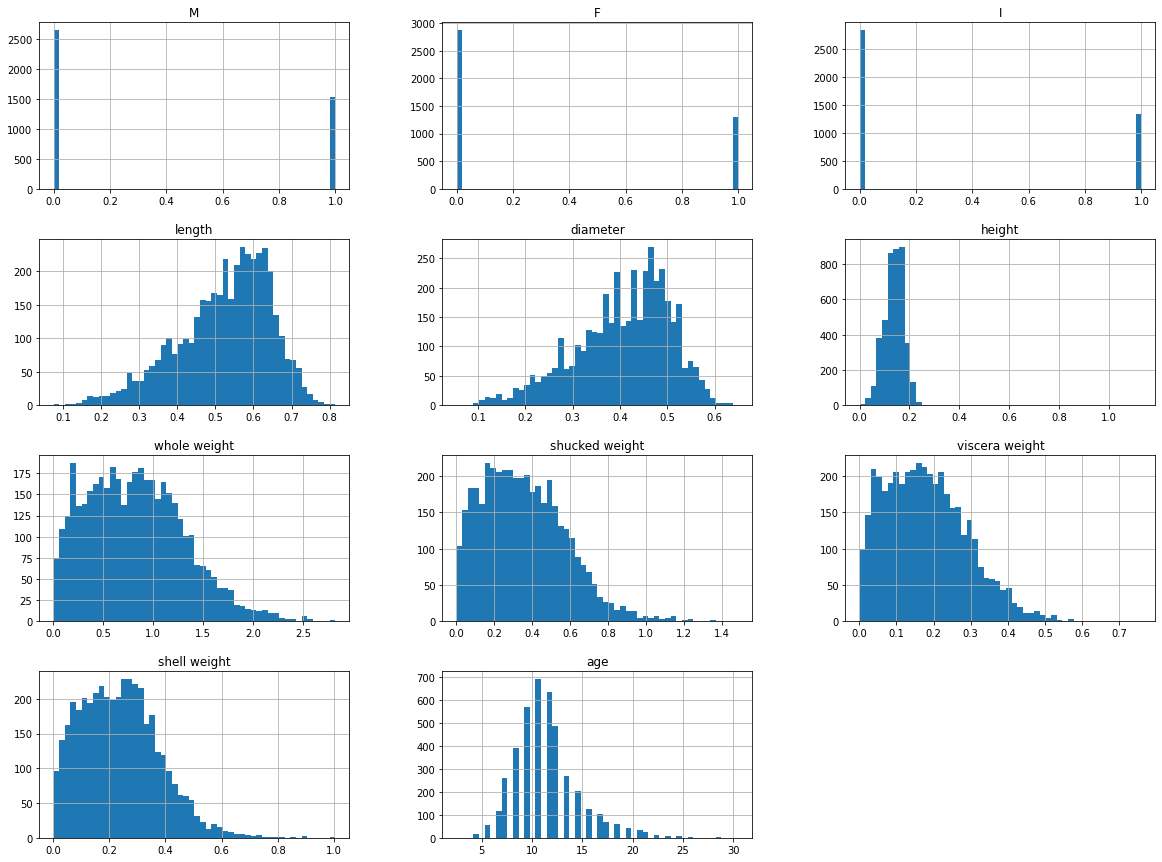

In [7]:
df.hist(bins=50, figsize=(20,15))

In [8]:
df.describe()

,M,F,I,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.365813,0.312904,0.321283,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,11.433684
std,0.481715,0.463731,0.467025,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.000000,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,2.500000
25%,0.000000,0.000000,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,9.500000
50%,0.000000,0.000000,0.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,10.500000
75%,1.000000,1.000000,1.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,12.500000
max,1.000000,1.000000,1.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,30.500000


Checking Correlation with Target Feature

In [9]:
df.corr()['age'].sort_values(ascending=False)

age               1.000000
shell weight      0.627574
diameter          0.574660
height            0.557467
length            0.556720
whole weight      0.540390
viscera weight    0.503819
shucked weight    0.420884
F                 0.250279
M                 0.181831
I                -0.436063
Name: age, dtype: float64

Seaborn Pair Plot

In [10]:
# Comment out to save time

"""
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

g = sns.PairGrid(df)

g.map_upper(plt.scatter, s=10, color = 'red')

g.map_diag(sns.distplot, kde=False, color = 'red')

g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);
"""

'\ndef corrfunc(x, y, **kws):\n    r, _ = stats.pearsonr(x, y)\n    ax = plt.gca()\n    ax.annotate("r = {:.2f}".format(r),\n                xy=(.1, .6), xycoords=ax.transAxes,\n               size = 24)\n    \ncmap = sns.cubehelix_palette(light=1, dark = 0.1,\n                             hue = 0.5, as_cmap=True)\n\nsns.set_context(font_scale=2)\n\ng = sns.PairGrid(df)\n\ng.map_upper(plt.scatter, s=10, color = \'red\')\n\ng.map_diag(sns.distplot, kde=False, color = \'red\')\n\ng.map_lower(sns.kdeplot, cmap = cmap)\ng.map_lower(corrfunc);\n'

# Data Preprocessing

Create new columns for the ratios and error.

In [11]:
df['viscera/w'] = df['viscera weight']/df['whole weight']
df['shucked/w'] = df['shucked weight']/df['whole weight']
df['shell/w']   = df['shucked weight']/df['whole weight']
df['err']       = abs(df['shucked weight']+df['shell weight']+df['viscera weight']-df['whole weight'])

then we graph the distribution of the data using the new columns we got.

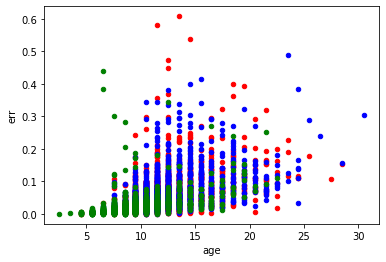

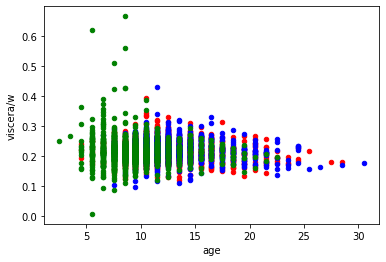

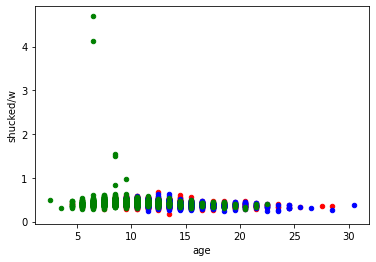

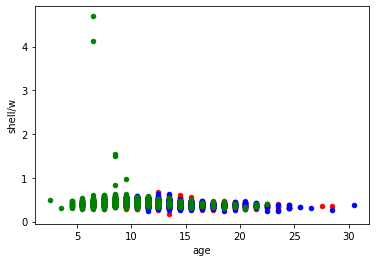

In [12]:
def graph_lable(lable):
    a = plt.gca()
    df.loc[df['M']==1].plot(kind='scatter',x = 'age',y = lable,color='red',ax=a)
    df.loc[df['F']==1].plot(kind='scatter',x = 'age',y = lable,color='blue',ax=a)
    df.loc[df['I']==1].plot(kind='scatter',x = 'age',y = lable,color='green',ax=a)
    plt.show()
graph_lable('err')
graph_lable('viscera/w')
graph_lable('shucked/w')
graph_lable('shell/w')

In [13]:
bad_data    =  [set(df[df['err']>0.1].index),
                set(df[df['shucked/w']>0.6].index),
                set(df[df['shell/w']>0.56].index),
                set(df[df['viscera/w']>0.4].index)]
union       = set().union(*bad_data)
df = df.drop(union)

In [14]:
print(df.corr().abs()['age'].sort_values(ascending=False))
df = df.drop(columns=['F','M','I','viscera/w','shucked/w','shell/w','err'])

age               1.000000
shell weight      0.615389
diameter          0.579821
length            0.563341
height            0.548349
err               0.530251
whole weight      0.523393
viscera weight    0.502288
I                 0.435073
shucked weight    0.431871
F                 0.259732
shell/w           0.228436
shucked/w         0.228436
M                 0.190985
viscera/w         0.015461
Name: age, dtype: float64


In [15]:
df = df.sample(frac=1)

df.info()
y = df['age'].to_numpy()
X = df.drop(columns='age').to_numpy()

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599 entries, 2438 to 2868
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   length          3599 non-null   float64
 1   diameter        3599 non-null   float64
 2   height          3599 non-null   float64
 3   whole weight    3599 non-null   float64
 4   shucked weight  3599 non-null   float64
 5   viscera weight  3599 non-null   float64
 6   shell weight    3599 non-null   float64
 7   age             3599 non-null   float64
dtypes: float64(8)
memory usage: 253.1 KB


# Models

## Bayesian Ridge Regression

In [16]:
param_grid = {'n_iter': [1, 5, 100], 
              'alpha_1': [.000001, .0001], 'alpha_2': [1, 5, 500],
              'lambda_1': [.1, .5, 100], 'lambda_2': [.00000001, .000001, .0001]}

br  = BayesianRidge()
br_cv = GridSearchCV(br, param_grid, scoring='neg_mean_absolute_error', cv=10, verbose=2, n_jobs=-1)

br_cv.fit(X_train, y_train)

params_optimal_br = br_cv.best_params_

optimal_br = BayesianRidge(**params_optimal_br)

optimal_br.fit(X_train, y_train)

y_predict = optimal_br.predict(X_test)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:    3.0s finished


In [17]:
br_pca  = BayesianRidge()

br_pca_cv = GridSearchCV(br, param_grid, scoring='neg_mean_absolute_error', cv=10, verbose=2, n_jobs=-1)

br_pca_cv.fit(X_train_pca, y_train_pca)

params_optimal_br_pca = br_pca_cv.best_params_

optimal_br_pca = BayesianRidge(**params_optimal_br_pca)

optimal_br_pca.fit(X_train_pca, y_train_pca)

y_predict_pca = optimal_br_pca.predict(X_test_pca)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


Fitting 10 folds for each of 162 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Done 1373 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:    0.8s finished


In [18]:
print('Bayesian Ridge Regression')
print('Optimal Parameters')
print(params_optimal_br)
print('Mean Absolute Error')
print(mean_absolute_error(y_test, y_predict))
print('R2 Score')
print(r2_score(y_test, y_predict))

print('\n')

print('Bayesian Ridge Regression w/ PCA')
print('Optimal Parameters')
print(params_optimal_br_pca)
print('Mean Absolute Error')
print(mean_absolute_error(y_test_pca, y_predict_pca))
print('R2 Score')
print(r2_score(y_test_pca, y_predict_pca))

Bayesian Ridge Regression
Optimal Parameters
{'alpha_1': 1e-06, 'alpha_2': 500, 'lambda_1': 0.5, 'lambda_2': 1e-08, 'n_iter': 1}
Mean Absolute Error
1.46595823668488
R2 Score
0.5228787186916481


Bayesian Ridge Regression w/ PCA
Optimal Parameters
{'alpha_1': 1e-06, 'alpha_2': 500, 'lambda_1': 0.5, 'lambda_2': 1e-08, 'n_iter': 1}
Mean Absolute Error
1.444541262061212
R2 Score
0.5058531578185333


## Stochastic Gradient Descent

In [19]:
param_grid = {'alpha': [0.001, .00001, .000001], 'penalty': ['elasticnet'],
              'l1_ratio': [0.5, 0.2, 0.1], 'max_iter':[15000, 20000, 30000],'eta0': [.1, .01, 0.001]}

sgd = SGDRegressor()
sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_absolute_error', cv=10, verbose=2, n_jobs=-1)

sgd_cv.fit(X_train, y_train)

params_optimal_sgd = sgd_cv.best_params_

optimal_sgd = SGDRegressor(**params_optimal_sgd)

optimal_sgd.fit(X_train, y_train)

y_predict = optimal_sgd.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 749 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    6.7s finished


In [20]:
sgd_pca_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_absolute_error', cv=10, verbose=2, n_jobs=-1)

sgd_pca_cv.fit(X_train_pca, y_train_pca)

params_optimal_sgd_pca = sgd_pca_cv.best_params_

optimal_sgd_pca = SGDRegressor(**params_optimal_sgd_pca)

optimal_sgd_pca.fit(X_train_pca, y_train_pca)

y_predict_pca = optimal_sgd_pca.predict(X_test_pca)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s


Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done 749 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    4.9s finished


In [21]:
print('Stochastic Gradient Descent')
print('Optimal Parameters')
print(params_optimal_sgd)
print('Mean Absolute Error')
print(mean_absolute_error(y_test, y_predict))
print('R2 Score')
print(r2_score(y_test, y_predict))

print('\n')

print('Stochastic Gradient Descent w/ PCA')
print('Optimal Parameters')
print(params_optimal_sgd_pca)
print('Mean Absolute Error')
print(mean_absolute_error(y_test_pca, y_predict_pca))
print('R2 Score')
print(r2_score(y_test_pca, y_predict_pca))

Stochastic Gradient Descent
Optimal Parameters
{'alpha': 1e-06, 'eta0': 0.1, 'l1_ratio': 0.1, 'max_iter': 20000, 'penalty': 'elasticnet'}
Mean Absolute Error
1.4861573892134408
R2 Score
0.5107776981026959


Stochastic Gradient Descent w/ PCA
Optimal Parameters
{'alpha': 1e-05, 'eta0': 0.1, 'l1_ratio': 0.5, 'max_iter': 15000, 'penalty': 'elasticnet'}
Mean Absolute Error
1.444952381792548
R2 Score
0.503734120054897


## Random Forest Regressor

In [22]:
param_grid = {'n_estimators': [50, 500, 1500], 'min_samples_split': [10, 25, 50]}

rf = RandomForestRegressor()
rf_cv = GridSearchCV(rf, param_grid, scoring='neg_mean_absolute_error', cv = 10, verbose=2, n_jobs=-1)

rf_cv.fit(X_train, y_train)

params_optimal_rf = rf_cv.best_params_

optimal_rf = RandomForestRegressor(**params_optimal_rf)

optimal_rf.fit(X_train, y_train)

y_predict = optimal_rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


In [23]:
rf_pca_cv = GridSearchCV(rf, param_grid, scoring='neg_mean_absolute_error', cv = 10, verbose=2, n_jobs=-1)

rf_pca_cv.fit(X_train_pca, y_train_pca)

params_optimal_rf_pca = rf_pca_cv.best_params_

optimal_rf_pca = RandomForestRegressor(**params_optimal_rf_pca)

optimal_rf_pca.fit(X_train_pca, y_train_pca)

y_predict_pca = optimal_rf_pca.predict(X_test_pca)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.1min finished


In [24]:
print('Random Forest Regressor')
print('Optimal Parameters')
print(params_optimal_rf)
print('Mean Absolute Error')
print(mean_absolute_error(y_test, y_predict))
print('R2 Score')
print(r2_score(y_test, y_predict))

print('\n')

print('Random Forest Regressor w/ PCA')
print('Optimal Parameters')
print(params_optimal_rf_pca)
print('Mean Absolute Error')
print(mean_absolute_error(y_test_pca, y_predict_pca))
print('R2 Score')
print(r2_score(y_test_pca, y_predict_pca))

Random Forest Regressor
Optimal Parameters
{'min_samples_split': 25, 'n_estimators': 1500}
Mean Absolute Error
1.3775921763352423
R2 Score
0.563206082942264


Random Forest Regressor w/ PCA
Optimal Parameters
{'min_samples_split': 50, 'n_estimators': 1500}
Mean Absolute Error
1.3380908314906814
R2 Score
0.5361558416150738
